In [1]:
# Dependencies
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, NGram
from pyspark.sql.functions import length
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [2]:
file_name = "reviews_users_50-100.csv"
yelp_review_df = pd.read_csv(file_name, encoding = "ISO-8859-1")
yelp_review_df.head()

,name,review_id,user_id,business_id,stars,text,date,review_count
0,"""Brick House Tavern + Tap""",ZflgoahrEd1_H0tWSATjQw,KgQnRvsPSrJJTOCp-reYZA,PfOCPjBrlQAnz__NXj9h_w,4,Eating on couches or lounging in comfy recline...,2016-02-27,57
1,"""Whole Foods Market""",JjJyUhnLtX5aZWVJfSeLKA,KgQnRvsPSrJJTOCp-reYZA,NFv21m2Czqz2XM5G4kpbKg,3,"Convienent easy parking, though I had to avoid...",2016-12-27,57
2,"""Crave Cantina""",hQu_gojfKPm8C0yovoszhQ,KgQnRvsPSrJJTOCp-reYZA,OFaMjL9nLF-A51KHNW8nfg,5,I usually go somewhere local twice before writ...,2017-07-01,57
3,"""Newdle Bar""",0n1w0w1VsRF4eqeqZHnX4g,KgQnRvsPSrJJTOCp-reYZA,XHK_1UM4CBZQ7RemDFr1mQ,3,Meh...don't come here if you are looking for a...,2016-08-11,57
4,"""Cornerstone Market & Deli""",PAldTKppEliQBy3M5vxtlg,KgQnRvsPSrJJTOCp-reYZA,eZ423jsTh3g9QTt2w-UTyg,5,This place is a gem...I was so glad they reope...,2016-08-17,57


In [3]:
short_yelp_review_df = yelp_review_df.iloc[:70000]


In [4]:
test_df = short_yelp_review_df[["review_id", "text","stars"]].reset_index()
test_df = test_df[["review_id",'text', 'stars']]
test_df.head()

,review_id,text,stars
0,ZflgoahrEd1_H0tWSATjQw,Eating on couches or lounging in comfy recline...,4
1,JjJyUhnLtX5aZWVJfSeLKA,"Convienent easy parking, though I had to avoid...",3
2,hQu_gojfKPm8C0yovoszhQ,I usually go somewhere local twice before writ...,5
3,0n1w0w1VsRF4eqeqZHnX4g,Meh...don't come here if you are looking for a...,3
4,PAldTKppEliQBy3M5vxtlg,This place is a gem...I was so glad they reope...,5


In [5]:
spark = SparkSession.builder.appName('Yelp').getOrCreate()

In [6]:
start_data = spark.createDataFrame(test_df)

In [7]:

data = start_data.withColumn('length', length(start_data['text']))

data.show()

+--------------------+--------------------+-----+------+
|           review_id|                text|stars|length|
+--------------------+--------------------+-----+------+
|ZflgoahrEd1_H0tWS...|Eating on couches...|    4|   744|
|JjJyUhnLtX5aZWVJf...|Convienent easy p...|    3|   668|
|hQu_gojfKPm8C0yov...|I usually go some...|    5|  1019|
|0n1w0w1VsRF4eqeqZ...|Meh...don't come ...|    3|   559|
|PAldTKppEliQBy3M5...|This place is a g...|    5|   569|
|r8ghBuwFFMybBGFcD...|Step back in time...|    4|   345|
|PTldCrPlj6FbJnekN...|I have been twice...|    4|   695|
|I1NMsaLQXLQRFEJwk...|This restaurant g...|    5|   639|
|moFCqVwlzeUE4em5P...|We will be back h...|    5|   537|
|oEa4Csf_LjOQHiwRa...|Came in due to re...|    3|   525|
|otCspYf4Vzo97zAuo...|Always great, fas...|    4|   222|
|n3DUEVDu2zbm4ewGS...|We have been here...|    4|   271|
|fPbWkOn2hhkNu8JvZ...|The smell of cara...|    5|   597|
|bVpzB-6wfMz_easvZ...|Preferred lunch v...|    3|   845|
|aT_6C6KU64l87unF7...|Great bur

In [8]:
# Create all the features to the data set

stars_to_num = StringIndexer(inputCol='stars',outputCol='label')
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
ngram = NGram(n=2, inputCol="token_text", outputCol="ngrams")
stopremove = StopWordsRemover(inputCol="ngrams",outputCol='stop_tokens')
hashingTF = HashingTF(inputCol='stop_tokens', outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [9]:
# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

In [10]:
data_prep_pipeline = Pipeline(stages=[stars_to_num, tokenizer, ngram, stopremove, hashingTF, idf, clean_up]) 

In [11]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data)
cleaned = cleaner.transform(data)

In [12]:
cleaned.select(['label', 'features']).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262145,[303,3143...|
|  2.0|(262145,[733,811,...|
|  1.0|(262145,[258,429,...|
|  2.0|(262145,[43,1479,...|
|  1.0|(262145,[1634,399...|
|  0.0|(262145,[7787,831...|
|  0.0|(262145,[43,815,1...|
|  1.0|(262145,[1447,369...|
|  1.0|(262145,[2826,552...|
|  2.0|(262145,[43,964,2...|
|  0.0|(262145,[22553,33...|
|  0.0|(262145,[5355,600...|
|  1.0|(262145,[1447,437...|
|  2.0|(262145,[8755,108...|
|  1.0|(262145,[2925,898...|
|  0.0|(262145,[83,1447,...|
|  2.0|(262145,[1413,281...|
|  2.0|(262145,[207,732,...|
|  0.0|(262145,[5155,600...|
|  1.0|(262145,[1481,314...|
+-----+--------------------+
only showing top 20 rows



In [13]:
# Break data down into a training set and a testing set
(training, testing) = cleaned.randomSplit([0.7, 0.3])

In [14]:
# Create a Naive Bayes model and fit training data
nb = NaiveBayes(smoothing=1.0, modelType='multinomial')   
star_predictor = nb.fit(training)

In [15]:
# Tranform the model with the testing data
test_results = star_predictor.transform(testing)
test_results.show(5)

+--------------------+--------------------+-----+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|           review_id|                text|stars|length|label|          token_text|              ngrams|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|--VE-t7k_ykSu2mlK...|I work in Park Ce...|    4|   615|  0.0|[i, work, in, par...|[i work, work in,...|[i work, work in,...|(262144,[4865,600...|(262144,[4865,600...|(262145,[4865,600...|[-8922.0932401670...|[0.95620643550424...|       0.0|
|--yzATieNipvZ7tVu...|This place

In [16]:
# Use the Class Evaluator for a cleaner description


acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print(f"Accuracy of model at predicting reviews was: {acc}")

Accuracy of model at predicting reviews was: 0.4389972107129357


In [17]:
test_results_pandas_df = test_results.select("review_id","stars", "label", "prediction").toPandas()
test_results_pandas_df.head()

,review_id,stars,label,prediction
0,--VE-t7k_ykSu2mlKpKwqA,4,0.0,0.0
1,--yzATieNipvZ7tVuTvNKw,5,1.0,0.0
2,-0HGoSW-aswXr2dlcqb9Dw,4,0.0,2.0
3,-0sjL8VTtLDLBBywRG6NJg,4,0.0,1.0
4,-2ayGrxgMlRAQpix5RZtTA,4,0.0,1.0


In [18]:
test_results_pandas_df[test_results_pandas_df["review_id"] == 'NHuuLXPWt9d9JXmptz3zjg']

,review_id,stars,label,prediction


In [19]:
test_results_pandas_df[test_results_pandas_df["review_id"] == '0n1w0w1VsRF4eqeqZHnX4g']

,review_id,stars,label,prediction
153,0n1w0w1VsRF4eqeqZHnX4g,3,2.0,2.0


In [20]:

reviewer_rating = []
ML_rating = []

reviewer_rating.append(test_results_pandas_df[(test_results_pandas_df['label']==4.0)]['label'].count())
ML_rating.append(test_results_pandas_df[(test_results_pandas_df['prediction']==4.0)]['prediction'].count())

reviewer_rating.append(test_results_pandas_df[(test_results_pandas_df['label']==3.0)]['label'].count())
ML_rating.append(test_results_pandas_df[(test_results_pandas_df['prediction']==3.0)]['prediction'].count())

reviewer_rating.append(test_results_pandas_df[(test_results_pandas_df['label']==2.0)]['label'].count())
ML_rating.append(test_results_pandas_df[(test_results_pandas_df['prediction']==2.0)]['prediction'].count())

reviewer_rating.append(test_results_pandas_df[(test_results_pandas_df['label']==0.0)]['label'].count())
ML_rating.append(test_results_pandas_df[(test_results_pandas_df['prediction']==0.0)]['prediction'].count())

reviewer_rating.append(test_results_pandas_df[(test_results_pandas_df['label']==1.0)]['label'].count())
ML_rating.append(test_results_pandas_df[(test_results_pandas_df['prediction']==1.0)]['prediction'].count())
 
reviewer_rating    


[1121, 1942, 4351, 7978, 5500]

In [21]:
ML_rating

[502, 1139, 3425, 11054, 4772]

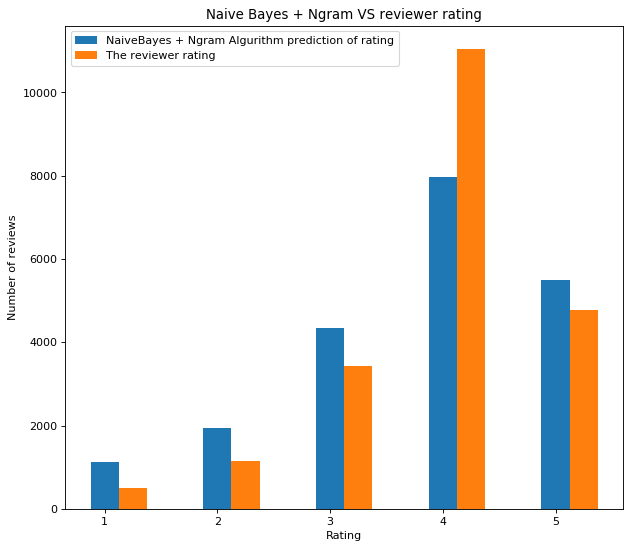

In [22]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')

x_range = np.arange(5)
width = 0.25

plt.bar(x_range+1, reviewer_rating, width)
plt.bar(x_range+1 + width, ML_rating, width)


plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.title('Naive Bayes + Ngram VS reviewer rating')
plt.legend(['NaiveBayes + Ngram Algurithm prediction of rating', 'The reviewer rating'])

plt.show()

In [ ]:
test_results_pandas_df.to_csv("NavieBays_testresult.csv")

In [ ]:
spark.stop()